In [1]:
import os
import sys
import pickle
import numpy as np
import scipy as sc
from subprocess import call
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable, grad
import time
import numpy as np

In [3]:
batch_size = 64
batch_num = 256
epochs = 500
seed = 1
lr = 0.001
momentum = 0.5
log_interval = 10
PATH = "model" # model path
cuda = torch.cuda.is_available()

if cuda:
    torch.cuda.manual_seed(seed)

In [4]:
def get_batch(n):
    # create some data
    X = np.random.rand(batch_size)
    np.random.shuffle(X)    # randomize the data
    Y = np.sin(5*np.pi*X)/(5*np.pi*X)
    X = torch.from_numpy(X).unsqueeze(1).float()
    Y = torch.from_numpy(Y).unsqueeze(1).float()
    return X, Y

In [5]:
X, Y = [], []
for i in range(batch_num):
    x, y = get_batch(batch_size)
    X.append(x)
    Y.append(y)

print (len(X), len(Y))

256 256


In [6]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__() #load super class for training data
        self.fc1 = nn.Linear(1, 5)
        self.fc2 = nn.Linear(5, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, x): #feed forward
        layer1 = self.fc1(x)
        layer2 = self.fc2(layer1)
        layer3 = self.fc3(layer2)
        return layer3

In [7]:
model = DNN()
if cuda:
    model.cuda()
print (model)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
print (optimizer)

DNN(
  (fc1): Linear(in_features=1, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
)


In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
cnt = count_parameters(model)
print (cnt)

46


In [10]:
loss_history = []

In [11]:
def train(epoch):
    model.train()
    for batch_idx in range(len(X)):
        data, target = X[batch_idx], Y[batch_idx]
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.data[0])
        return loss.data[0]

In [12]:
for epoch in range(epochs):
    loss = train(epoch)
    print ('Epoch', epoch, 'loss:', loss, end='\r')

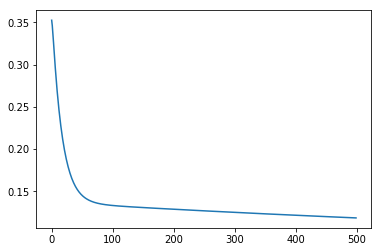

In [13]:
plt.clf()
e = list(range(len(loss_history)))
plt.plot(e, loss_history)
plt.show()

In [14]:
test_x, test_y = get_batch(64)
test_x, test_y = test_x.cuda(), test_y.cuda()
test_x, test_y = Variable(test_x, volatile=True), Variable(test_y)

In [15]:
def test():
    model.eval()
    test_loss = 0
    
    output = model(test_x)
    test_loss += F.mse_loss(output, test_y, size_average=False).data[0] # sum up batch loss
        
    test_loss /= len(test_x)
    return test_loss

In [16]:
perturb = np.linspace(-1e-3, 1e-3, 50)

In [17]:
loss_history = []
for p in model.parameters():
    for pp in p:
        for ppp in pp:
            tmp = []
            for i in perturb:
                ppp.data += i
                loss = test()
                tmp.append(loss)
                ppp.data -= i
            loss_history.append(tmp)

In [18]:
print (np.array(loss_history).shape)

(46, 50)


In [19]:
colormap = plt.cm.gist_ncar
colors = [colormap(i) for i in np.linspace(0, 0.9, cnt)]
colors = [i[:3] for i in colors]
print (len(colors))

46


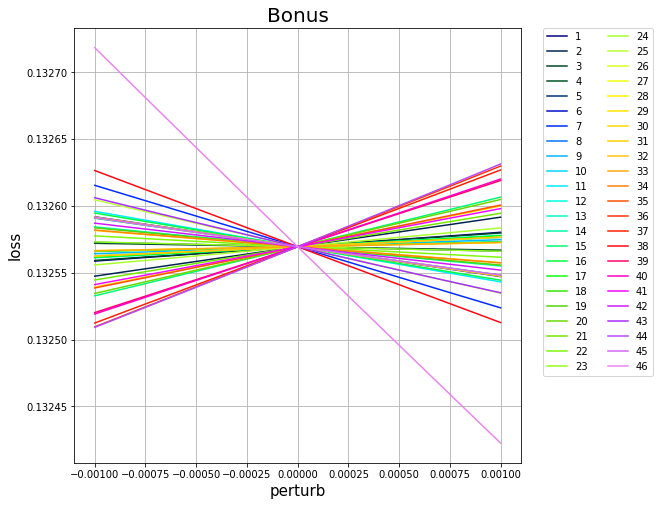

In [20]:
fig = plt.figure(figsize = (8,8))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_ylabel('loss', fontsize = 15)
ax.set_xlabel('perturb', fontsize = 15)
ax.set_title('Bonus', fontsize = 20)
cnt = 1
for i, j in zip(loss_history, colors):
    ax.plot(perturb, i, c=j, label=str(cnt))
    cnt += 1

ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0., ncol=2)
plt.savefig('bonus.png')